# **Data Preprocessing: Stage Four**

1.	Splitting the training data (window over sampling #1– duplication)
-	Get the duration for all the species
-	Do a 70-30 training and validation split for each species, so enough intraspecies sample variation
-	From the species with the longest duration in training, make that duration the benchmark for the training duration of all the species for a balanced training set.
-	So, you already know from the duration that the dataset is imbalanced, now you have to oversample the species with shorter duration in training to match the benchmark training duration. 
-	This is done by oversampling the minority by duplication until it reaches the same duration (basically duplicate samples from species with shorter duration until it matches the desired duration for balanced training)
-	[Find out problems with accurate representation of model performance by duplicating samples in validation] DONT DUPLICATE VALIDATION SAMPLES!
-	So now you have the desired training duration in each species. Now do a repeat of stage 3
-	You take audio samples from each species and convert those to their respective features using the windowing that worked best in stage 3
-	Ensure that the dimensions of all the features are the same

In this we are addressing the issue of imbalanced dataset by adding samples to the minority classes, instead of removing training samples from the majority classes. Duplicating samples without biasing certain audio clips more than others, ensuring each species reaches the target duration.

* Top window with features
* Second window with features
* Best between that with filtered audio

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
from scipy.signal import butter, filtfilt

In [2]:
df_train = pd.read_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/traintest-split/train.csv') # Reading in training data
df_train.head()

,Unnamed: 0,primary_label,type,rating,filename,duration,filename_npy
0,7169,gargan,song,4.5,gargan/XC190746.ogg,6.660000,gargan/XC190746.npy
1,4476,combul2,song,3.5,combul2/XC443499.ogg,47.592000,combul2/XC443499.npy
2,7483,gnbcam2,blank,1.5,gnbcam2/XC45693.ogg,16.378812,gnbcam2/XC45693.npy
3,13632,tafpri1,call,4.0,tafpri1/XC363881.ogg,19.043250,tafpri1/XC363881.npy
4,14773,wbrcha2,song,3.5,wbrcha2/XC227360.ogg,93.753500,wbrcha2/XC227360.npy


In [3]:
df_train['primary_label'].value_counts()

primary_label
litegr     262
combul2    220
rbsrob1    190
greegr     183
blakit1    182
gnbcam2    174
rerswa1    156
somgre1    133
blbpuf2    123
ratcis1    123
tafpri1    121
colsun2    121
egygoo     113
categr     104
carcha1     97
gargan      94
yertin1     94
grecor      92
fotdro5     89
wbrcha2     86
Name: count, dtype: int64

In [4]:
filepaths = df_train['filename_npy']
filepaths

0        gargan/XC190746.npy
1       combul2/XC443499.npy
2        gnbcam2/XC45693.npy
3       tafpri1/XC363881.npy
4       wbrcha2/XC227360.npy
                ...         
2752    rerswa1/XC278139.npy
2753    rerswa1/XC310320.npy
2754    combul2/XC239845.npy
2755    somgre1/XC154317.npy
2756      grecor/XC27183.npy
Name: filename_npy, Length: 2757, dtype: object

## Get the durations for all the species

In [5]:
duration_sum = df_train[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,primary_label,duration,duration_mins
19,yertin1,3039.921813,50.665364
18,wbrcha2,4188.970125,69.816169
17,tafpri1,3091.966500,51.532775
16,somgre1,5975.104500,99.585075
15,rerswa1,5105.715938,85.095266
14,rbsrob1,8089.174500,134.819575
13,ratcis1,3813.778563,63.562976
12,litegr,6256.380688,104.273011
11,greegr,3072.503938,51.208399
10,grecor,6831.784187,113.863070


### From the species with the shortest duration, make 70% of that duration the benchmark for the training duration of all the species for balanced training

In [10]:
shuffled_train = df_train.sample(frac=1, random_state=4141) # shuffle the original df before splitting to train/val

In [139]:
def oversample_species(train_data, target_duration):
    oversampled_data = train_data # pd.DataFrame()
    target_duration = target_duration - 10
    
    for species in train_data['primary_label'].unique():
        species_df = train_data[train_data['primary_label'] == species].copy()
        species_duration = species_df['duration'].sum()
        species_df = species_df.sample(frac=1).reset_index(drop=True)
        
        # If species duration is less than the target duration, oversample
        while species_duration < target_duration:
            
                
            # Duplicate samples without repeating the same audio excessively
            for i in range(len(species_df)):
                sample = species_df.iloc[i:i+1]
                species_duration += sample['duration'].values[0]
                oversampled_data = pd.concat([oversampled_data, sample])
                
                
                if species_duration > target_duration:
                    # print(species + " duration: " + str(species_duration) + "s")
                    break
    duration_sum_train = oversampled_data[['primary_label', 'duration']].groupby('primary_label').sum('duration').sort_values('duration', ascending=False).reset_index()
    print(duration_sum_train)
    return oversampled_data

Intraspecies 70-30 split

In [70]:
def intraspecies_split(df, split_ratio=0.7):
    train_data = pd.DataFrame() 
    val_data = pd.DataFrame()    
    
    # Group by 'primary_label' and split within each species
    for species in df['primary_label'].unique():
        species_df = df[df['primary_label'] == species].copy()
        
        species_df = species_df.sample(frac=1, random_state=6969).reset_index(drop=True)
        train, val = train_test_split(species_df, train_size=split_ratio, random_state=69)
        
        # Concatenate the result back into the main train and validation dataframes
        train_data = pd.concat([train_data, train])
        val_data = pd.concat([val_data, val])
    
    # Reset the index of the final dataframes
    train_data = train_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
    
    return train_data, val_data

In [71]:
# Doing the intraspecies split
train_df, val_df = intraspecies_split(shuffled_train, split_ratio=0.7)

In [73]:
# Check the results
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 1922
Validation set size: 835


### Confirm no duplicates and the samples in validation set are not in the training set

In [74]:
assert len(val_df) == val_df['filename_npy'].nunique()

In [75]:
assert len(train_df) == train_df['filename_npy'].nunique()

In [76]:
is_present = val_df['filename_npy'].isin(train_df['filename_npy']).any()

assert not is_present, "Validation set contains samples from training set!"

### Time for duplication of samples until it reaches max duration

In [46]:
train_df['primary_label'].unique()

array(['rbsrob1', 'blakit1', 'egygoo', 'somgre1', 'wbrcha2', 'rerswa1',
       'ratcis1', 'colsun2', 'blbpuf2', 'greegr', 'litegr', 'combul2',
       'tafpri1', 'gnbcam2', 'gargan', 'categr', 'fotdro5', 'grecor',
       'carcha1', 'yertin1'], dtype=object)

In [31]:
train_df['primary_label'].value_counts()

primary_label
litegr     183
combul2    154
rbsrob1    133
greegr     128
blakit1    127
gnbcam2    121
rerswa1    109
somgre1     93
ratcis1     86
blbpuf2     86
tafpri1     84
colsun2     84
egygoo      79
categr      72
carcha1     67
gargan      65
yertin1     65
grecor      64
fotdro5     62
wbrcha2     60
Name: count, dtype: int64

In [121]:
duration_sum_train = train_df[['primary_label', 'duration']].groupby('primary_label').sum('duration').sort_values('duration', ascending=False).reset_index()
# duration_sum_train['duration_mins'] = duration_sum_train['duration'] / 60

print(duration_sum_train)

   primary_label     duration
0        combul2  7180.998625
1         grecor  6261.481125
2        blakit1  6207.358812
3        rbsrob1  5531.751000
4         litegr  4703.849438
5        somgre1  4246.006875
6        gnbcam2  3792.124500
7         categr  3254.741687
8        carcha1  3210.948563
9        rerswa1  3179.773375
10       colsun2  2837.802062
11        egygoo  2814.099438
12       ratcis1  2792.964687
13       fotdro5  2772.267063
14       wbrcha2  2684.431687
15        greegr  2333.242688
16       blbpuf2  2216.992125
17       yertin1  2209.415687
18       tafpri1  2112.089937
19        gargan  1768.505000


In [100]:
duration_benchmark = np.max(duration_sum_train['duration']) # maximum total duration for each species in the training set in seconds using sample with highest duration
duration_benchmark

7180.998625

In [144]:
# Perform oversampling to balance all species to match the longest duration
balanced_train = oversample_species(train_df, target_duration=duration_benchmark)

   primary_label     duration
0        wbrcha2  7381.012875
1        somgre1  7291.620875
2        rerswa1  7234.080687
3        yertin1  7217.887313
4         egygoo  7212.070000
5        tafpri1  7197.542062
6        carcha1  7196.161187
7        colsun2  7195.672812
8        rbsrob1  7187.745125
9        blakit1  7186.511438
10        categr  7184.882875
11        litegr  7181.370750
12       combul2  7180.998625
13       gnbcam2  7180.536875
14       fotdro5  7175.436188
15        greegr  7175.175875
16        grecor  7174.036250
17        gargan  7173.910625
18       ratcis1  7172.983313
19       blbpuf2  7171.010875


In [145]:
duration_sum_balanced = balanced_train[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('duration', ascending=False)
duration_sum_balanced['duration_mins'] = duration_sum_balanced['duration'] / 60

duration_sum_balanced

,primary_label,duration,duration_mins
18,wbrcha2,7381.012875,123.016881
16,somgre1,7291.620875,121.527015
15,rerswa1,7234.080687,120.568011
19,yertin1,7217.887313,120.298122
6,egygoo,7212.070000,120.201167
17,tafpri1,7197.542062,119.959034
2,carcha1,7196.161187,119.936020
4,colsun2,7195.672812,119.927880
14,rbsrob1,7187.745125,119.795752
0,blakit1,7186.511438,119.775191


### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [146]:
balanced_train['set'] = 'tr'
val_df['set'] = 'val'

merged_train = pd.concat([balanced_train, val_df])

In [147]:
duration_sum = merged_train[['primary_label', 'duration', 'set']].groupby(['set', 'primary_label']).sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,set,primary_label,duration,duration_mins
39,val,yertin1,830.506125,13.841769
19,tr,yertin1,7217.887313,120.298122
18,tr,wbrcha2,7381.012875,123.016881
38,val,wbrcha2,1504.538438,25.075641
17,tr,tafpri1,7197.542062,119.959034
37,val,tafpri1,979.876562,16.331276
16,tr,somgre1,7291.620875,121.527015
36,val,somgre1,1729.097625,28.818294
35,val,rerswa1,1925.942562,32.099043
15,tr,rerswa1,7234.080687,120.568011


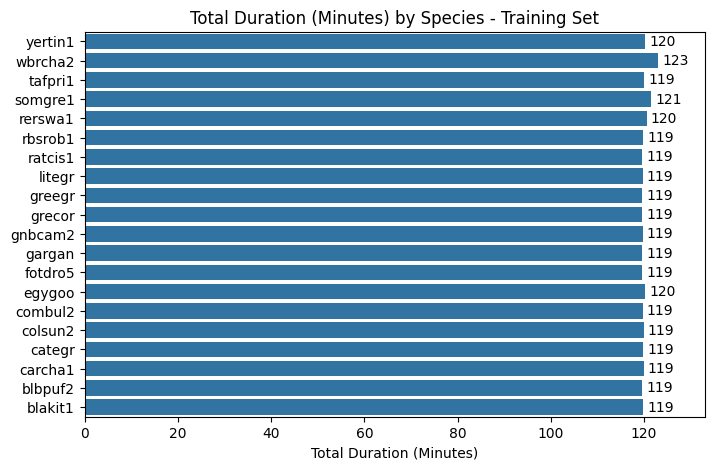

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

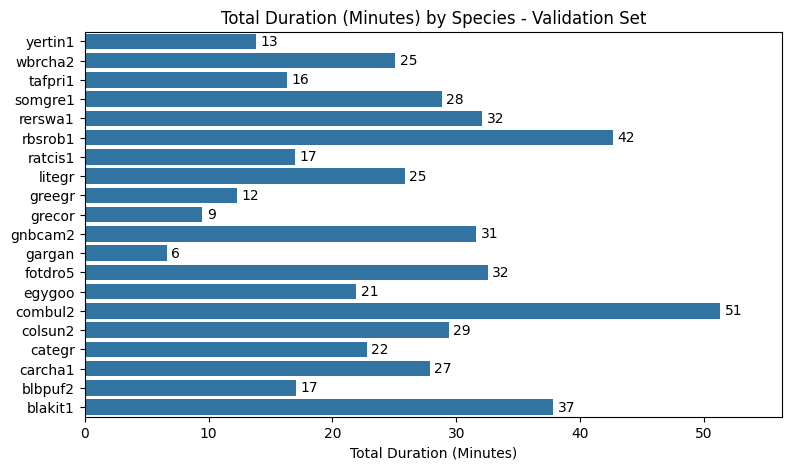

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 5])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [152]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-3-trainval.csv', index=False)

# Feature Extraction

Turning the data into Mel-spectrograms 

In [74]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/'  # Where to save features
n_mels = 128
target_shape = (128,128)
sr = 16000

In [20]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-3-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [21]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/train_features.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-3/val_features.pkl'


In [22]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [51]:
def bandpass_filter(audio, lowcut=500, highcut=7900, sr=sr, order=4):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to audio
    filtered_audio = filtfilt(b, a, audio)
    return filtered_audio

In [58]:
# Function to generate multiple features (Mel, RMS, Chroma, MFCC) with sliding window and overlap
def get_features_with_window(npy_file, filter=False, sr=sr, window_size=4, overlap=2, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        return None  # Skip short samples
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    features = []  # To store feature dictionaries
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        if filter:
            windowed_data = bandpass_filter(windowed_data)
        
        
        # Generate Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
        
        # Generate RMS Energy
        rms_energy = librosa.feature.rms(y=windowed_data)
        rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
        
        # Generate Chroma Frequencies
        chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
        chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
        
        # Generate MFCC
        mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
        mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
        
        # Append the feature set to the list as a dictionary
        features.append({
            "mel_spectrogram": mel_resized,
            "rms_energy": rms_resized,
            "chroma": chroma_resized,
            "mfcc": mfcc_resized
        })
    
    return features  # Returns a list of dictionaries containing all features for each window


In [72]:
def plot_all_features(npy_file, window_idx, filter=False, sr=sr, window_size=4, overlap=2, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    
    # Get the duration of the audio and ensure it's long enough
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        print("Audio too short for the specified window size.")
        return None
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    # Get the start and end points of the window
    start = window_idx * overlap_step
    end = start + step
    
    if end > len(audio_data):
        print(f"Window index {window_idx} exceeds audio length.")
        return None
    
    # Extract the windowed audio
    windowed_data = audio_data[start:end]
    if filter:
            windowed_data = bandpass_filter(windowed_data)

    
    # Generate the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
    
    # Generate the RMS Energy
    rms_energy = librosa.feature.rms(y=windowed_data)
    rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
    
    # Generate the Chroma Frequencies
    chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
    chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
    
    # Generate the MFCCs
    mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
    mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
    
    # Plot all features
    plt.figure(figsize=(20, 12))

    # Plot Mel Spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(mel_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Plot RMS Energy
    plt.subplot(2, 2, 2)
    librosa.display.specshow(rms_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title('RMS Energy')

    # Plot Chroma Frequencies
    plt.subplot(2, 2, 3)
    librosa.display.specshow(chroma_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chroma Frequencies')

    # Plot MFCC
    plt.subplot(2, 2, 4)
    librosa.display.specshow(mfcc_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

    # Play the audio for the selected window
    print(f"Playing audio window {window_idx} from {start/sr:.2f}s to {end/sr:.2f}s:")
    ipd.display(ipd.Audio(windowed_data, rate=sr))


### Visualizing Features

As you can see by changing the filter from True to False, choosing to use the filter enhances the features strongly.

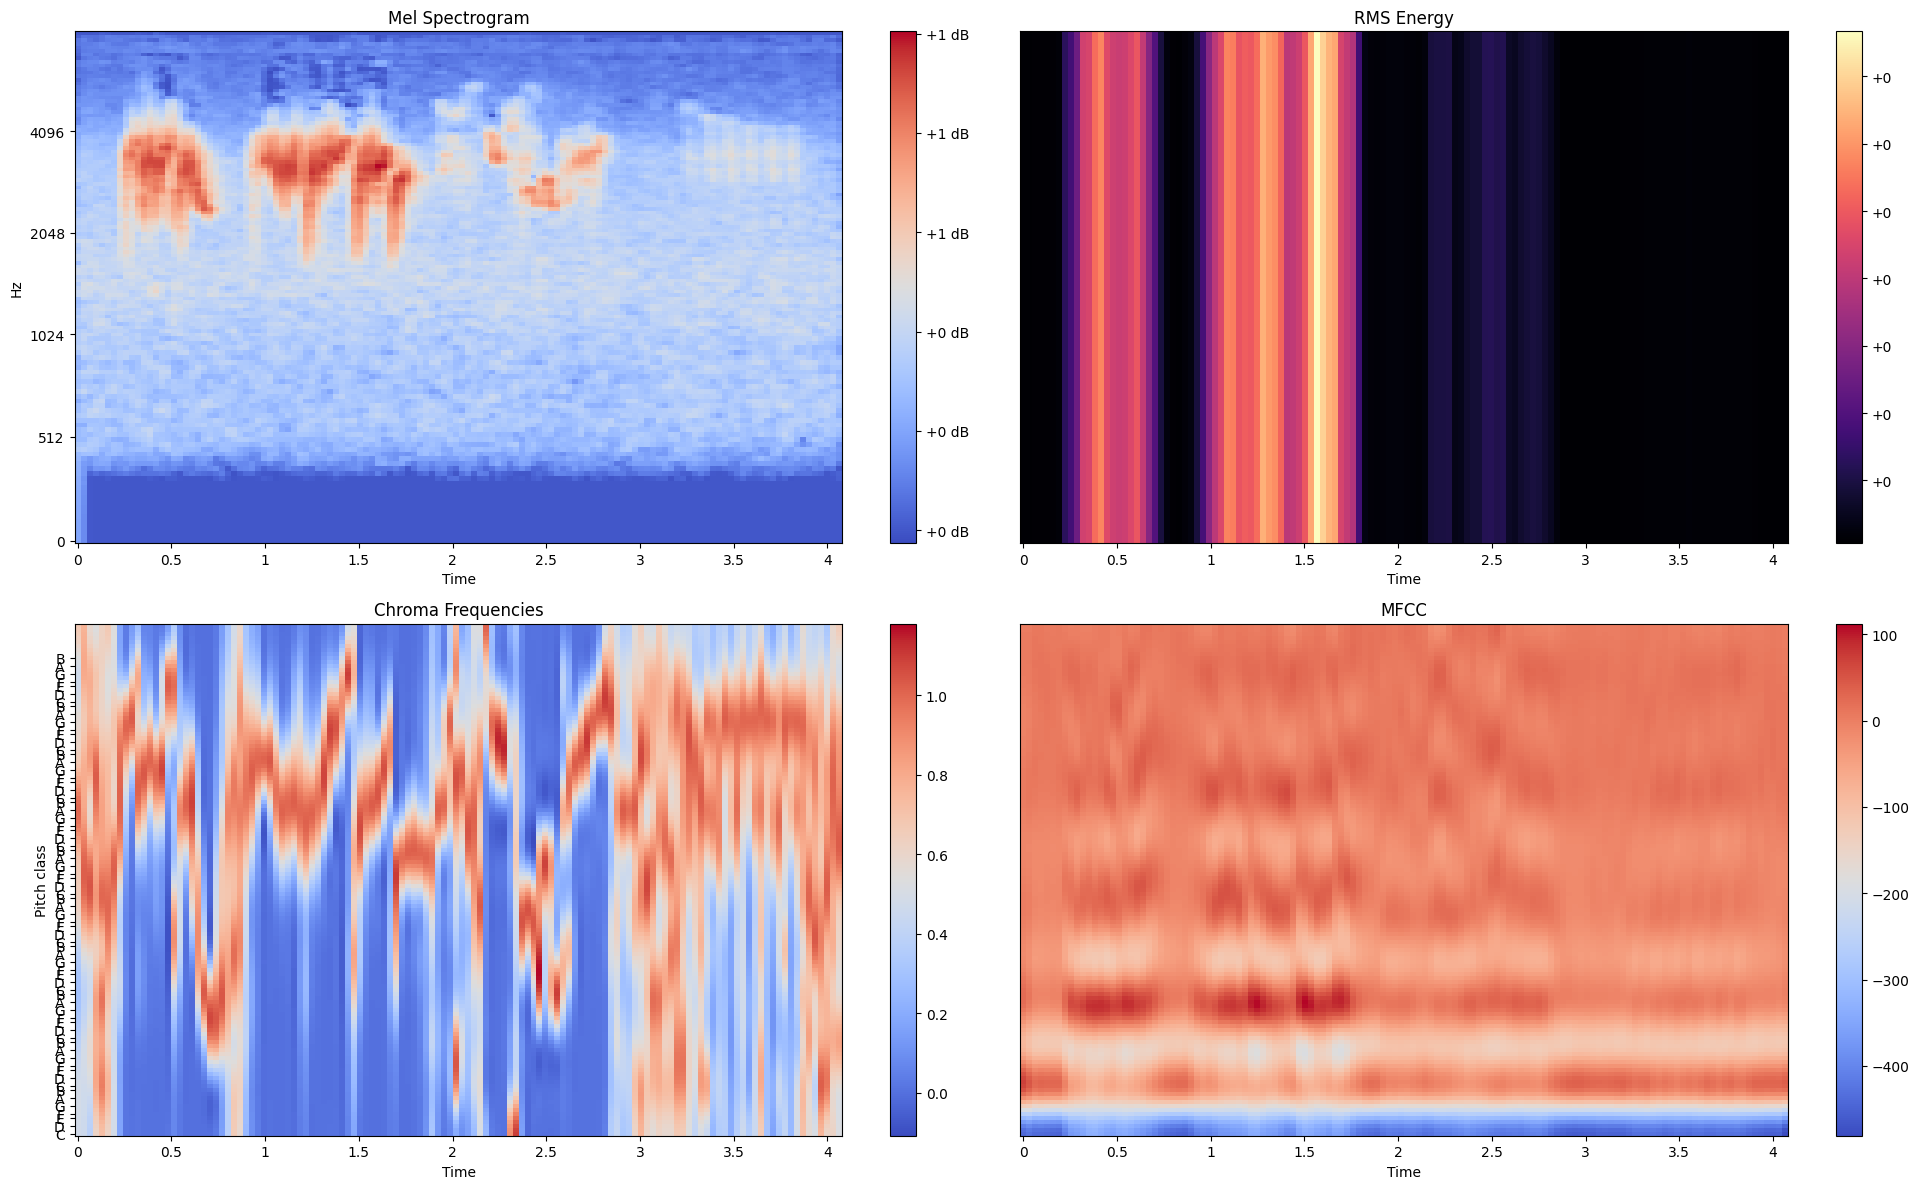

Playing audio window 4 from 8.00s to 12.00s:


In [81]:
npy_file = 'somgre1/XC154317.npy'
window_idx = 4
filter = True

plot_all_features(npy_file, window_idx, filter) # Plotting with the filter. 

In [24]:
# # Function to generate and organize Mel spectrograms in a dictionary
# def prepare_data_for_model_dict(npy_files, labels_encoded, sr=sr, window_size=8, overlap=4, target_shape=(128, 128)):
#     mel_spectrograms_dict = {}

#     for npy_file, label in tqdm(zip(npy_files, labels_encoded), desc="Processing files"):
#         mel_specs = get_mel_spectrogram_with_window(npy_file, sr=sr, window_size=window_size, overlap=overlap, target_shape=target_shape)
#         if mel_specs is None:
#             continue  # Skip short files
        
#         for i, mel_spec in enumerate(mel_specs):
#             mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add a channel dimension for CNN
#             key = f"{npy_file}_window_{i}"  # Create a unique key for each windowed spectrogram
#             mel_spectrograms_dict[key] = (mel_spec, label)  # Store the spectrogram and label as a tuple

#     return mel_spectrograms_dict


## Processing the training data

In [82]:
train_features = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training features", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        train_features[key] = (feature_set, label)

Processing files: 1it [00:00, 235.71it/s]%|          | 0/933 [00:00<?, ?it/s]
Processing files: 1it [00:00,  3.19it/s]
Processing files: 1it [00:00, 86.30it/s]0%|          | 4/933 [00:00<03:49,  4.05it/s]
Processing files: 1it [00:00,  2.80it/s]
Processing files: 1it [00:00, 159.33it/s]%|          | 6/933 [00:01<03:20,  4.63it/s]
Processing files: 1it [00:00,  1.19it/s]
Processing files: 1it [00:00,  8.11it/s]1%|          | 8/933 [00:02<04:42,  3.28it/s]
Processing files: 1it [00:00, 197.68it/s]%|          | 9/933 [00:02<04:03,  3.80it/s]
Processing files: 1it [00:00,  7.87it/s]
Processing files: 1it [00:00,  7.91it/s]1%|          | 11/933 [00:02<02:51,  5.39it/s]
Processing files: 1it [00:00, 229.88it/s]%|▏         | 12/933 [00:02<02:39,  5.78it/s]
Processing files: 1it [00:00,  1.40it/s]
Processing files: 1it [00:00, 14.47it/s]2%|▏         | 15/933 [00:03<03:22,  4.52it/s]
Processing files: 1it [00:00, 14.91it/s]
Processing files: 1it [00:00, 264.74it/s]%|▏         | 17/933 [00:03<02

In [84]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_mel_spectrograms, f)

## Processing the validation data

In [85]:
val_features = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing training features", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        val_features[key] = (feature_set, label)

Processing files: 1it [00:00, 10.67it/s]0%|          | 1/1824 [00:00<09:22,  3.24it/s]
Processing files: 1it [00:00,  1.52it/s]
Processing files: 1it [00:00, 11.00it/s]1%|          | 10/1824 [00:03<11:26,  2.64it/s]
Processing files: 1it [00:00,  4.65it/s]
Processing files: 1it [00:00, 28.04it/s]1%|          | 13/1824 [00:03<07:32,  4.01it/s]
Processing files: 1it [00:00,  4.43it/s]
Processing files: 1it [00:00,  2.24it/s]1%|          | 17/1824 [00:04<05:59,  5.03it/s]
Processing files: 1it [00:00, 107.10it/s]%|          | 18/1824 [00:04<07:57,  3.79it/s]
Processing files: 1it [00:00, 295.02it/s]
Processing files: 1it [00:00, 446.82it/s]
Processing files: 1it [00:00, 244.67it/s]
Processing files: 1it [00:01,  1.09s/it]
Processing files: 1it [00:00, 22.64it/s]1%|▏         | 24/1824 [00:06<10:17,  2.92it/s]
Processing files: 1it [00:00,  1.78it/s]
Processing files: 1it [00:00, 10.39it/s]1%|▏         | 26/1824 [00:07<09:55,  3.02it/s]
Processing files: 1it [00:00,  6.19it/s]
Processing fi

In [86]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_mel_spectrograms, f)

## Plotting the spectrograms

So you can see that its not really a good way to do it this way

In [87]:
def view_mel_spectrogram_by_index(train_mel_spectrograms, index, isTrain=True):
    # Get the key for the chosen index
    key = list(train_mel_spectrograms.keys())[index]
    
    temp_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'
    

    
    # Extract mel spectrogram and label from the dictionary
    mel_spectrogram, label = train_mel_spectrograms[key]
    
    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram.squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram for {label} (Index: {index})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

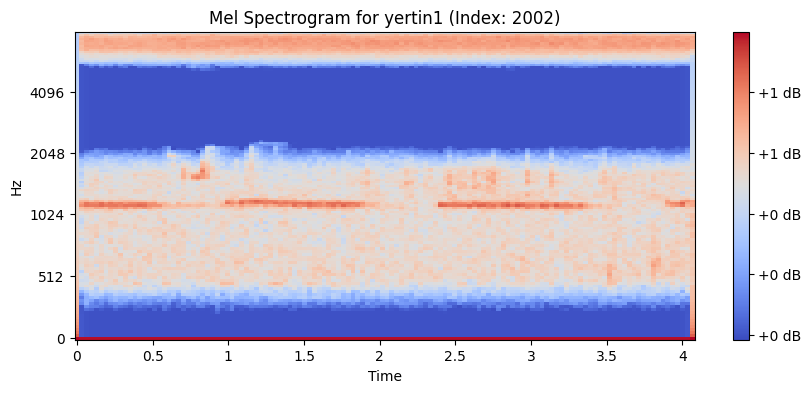

In [88]:
view_mel_spectrogram_by_index(train_mel_spectrograms, 2002)

# Confirming that the pickle files were saved correctly:

In [89]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms_2 = pickle.load(f)

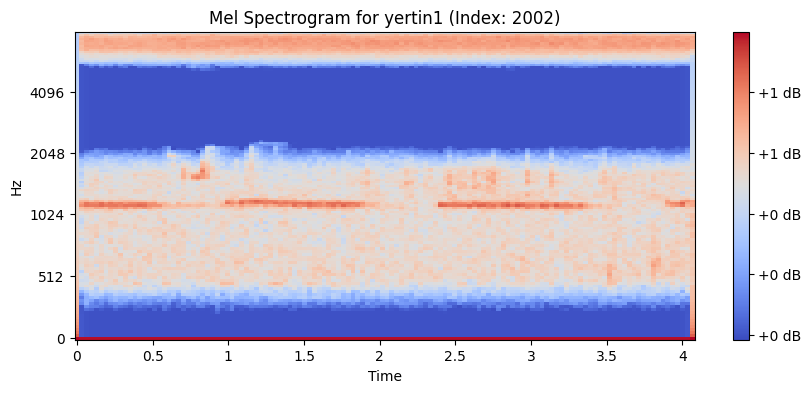

In [90]:
view_mel_spectrogram_by_index(train_mel_spectrograms_2, 2002)